## <font color='darkblue'>Preface</font>
(go/mlclass-colab-classification) So far, you've only created regression models. That is, you created models that produced floating-point predictions, such as, "houses in this neighborhood costs N thousand dollars." In this Colab, you'll create and evaluate a binary [classification model](https://developers.google.com/machine-learning/glossary/#classification_model).  That is, you'll create a model that answers a binary question. In this exercise, the binary question will be, "Are houses in this neighborhood above a certain price?"

### <font color='darkgreen'>Learning Objectives:</font>

After doing this notebook, you'll know how to:

  * Convert a regression question into a classification question.
  * Modify the classification threshold and determine how that modification influences the model.
  * Experiment with different classification metrics to determine your model's effectiveness.

### <font color='darkgreen'>Call the import statements</font>
The following code imports the necessary modules.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Ran the import statements.


## <font color='darkblue'>The Dataset</font>

Like several of the previous exercises, this notebook uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

### <font color='darkgreen'>Load the datasets from the internet</font>
The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

Unlike some of the previous Colabs, the preceding code cell did not scale the label (`median_house_value`).  The following section ("Normalize values") provides an alternative approach.

### <font color='darkgreen'>Normalize values</font>

<font size='3ptx'><b>When creating a model with multiple features, the values of each feature should cover roughly the same range.</b></font>  For example, if one feature's range spans 500 to 100,000 and another feature's range spans 2 to 12, then the model will be difficult or impossible to train. Therefore, you should 
[normalize](https://developers.google.com/machine-learning/glossary/#normalization) features in a multi-feature model. 

The following code cell normalizes datasets by converting each raw value (<font color='brown'>including the label</font>) to its [Z-score](https://en.wikipedia.org/wiki/Standard_score). A [**Z-score**](https://en.wikipedia.org/wiki/Standard_score) is the number of standard deviations from the mean for a particular raw value. For example, consider a feature having the following characteristics:

  * The mean is 60.
  * The standard deviation is 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

In [3]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3930,0.8,-0.7,0.4,-0.6,-0.7,-0.4,-0.6,0.1,-0.5
7578,0.6,-0.6,-1.4,6.7,5.5,6.4,6.0,1.1,0.2
8089,0.6,-0.9,0.6,-0.3,-0.6,-0.5,-0.5,2.2,2.5
8217,0.6,-0.7,0.0,1.3,2.2,0.8,2.1,-0.2,1.5
4970,0.7,-0.8,1.0,-0.8,-0.7,-0.6,-0.7,-0.8,-0.1


In [4]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

## <font color='darkblue'>Binary Classification</font>

### <font color='darkgreen'>Task 1: Create a binary label</font>

<font size='3ptx'><b>In classification problems, the label for every example must be either 0 or 1</b></font>. Unfortunately, the natural label in the California Housing Dataset, `median_house_value`, contains floating-point values like 80,100 or 85,700 rather than 0s and 1s, while the normalized version of `median_house_values` contains floating-point values primarily between -3 and +3.

Your task is to create a new column named `median_house_value_is_high` in both the training set and the test set . If the `median_house_value` is higher than a certain arbitrary value (<font color='brown'>defined by `threshold`</font>), then set `median_house_value_is_high` to 1. Otherwise, set `median_house_value_is_high` to 0. 

<font color='darkred'>**Hint:**</font> The cells in the `median_house_value_is_high` column must each hold `1` and `0`, not `True` and `False`. To convert `True` and `False` to  `1` and `0`, call the pandas DataFrame function [`astype(float)`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html). 

In [26]:
threshold = 265000 # This is the 75th percentile for median house values.
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float)

# Print out a few example cells from the beginning and 
# middle of the training set, just to make sure that
# your code created only 0s and 1s in the newly created
# median_house_value_is_high column
train_df_norm["median_house_value_is_high"].sample(n=20)

3370    0.0
3327    0.0
9655    1.0
4018    0.0
11716   0.0
         ..
9302    0.0
13857   1.0
2546    1.0
15419   0.0
6901    1.0
Name: median_house_value_is_high, Length: 20, dtype: float64

### <font color='darkgreen'>Represent features in feature columns</font>

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (<font color='brown'>collected in `feature_layer`</font>) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 

In [27]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[ 0.07411441, -0.5792179 ],
       [ 1.0833083 ,  6.741143  ],
       [ 2.20743   , -0.25260448],
       ...,
       [-0.11240069, -1.0512477 ],
       [ 0.42785898,  0.1588734 ],
       [ 0.9980952 , -0.07140743]], dtype=float32)>

### <font color='darkgreen'>Define functions that build and train a model</font>

The following code cell defines two functions:

  * `create_model(my_learning_rate, feature_layer, my_metrics)`, which defines the model's
    topography.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.

Prior exercises used [ReLU](https://developers.google.com/machine-learning/glossary#ReLU) as the [activation function](https://developers.google.com/machine-learning/glossary#activation_function). By contrast, this exercise uses [sigmoid](https://developers.google.com/machine-learning/glossary#sigmoid_function) as the activation function. 

In [28]:
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True, verbose=0):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, verbose=verbose)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


### <font color='darkgreen'>Define a plotting function</font>

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) function plots one or more curves, showing how various classification metrics change with each epoch.

In [29]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


### <font color='darkgreen'>Invoke the creating, training, and plotting functions</font>


The following code cell calls specify the hyperparameters, and then invokes the  functions to create and train the model, and then to plot the results.

In [30]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
metric_name = 'accuracy'
METRICS = [
  tf.keras.metrics.BinaryAccuracy(
    name=metric_name, threshold=classification_threshold)]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(
  my_model, train_df_norm, epochs, label_name, batch_size)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


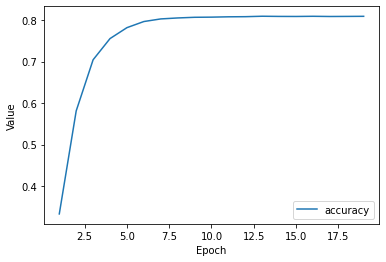

In [31]:
# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

Accuracy should gradually improve during training (<font color='brown'>until it can improve no more</font>).

### <font color='darkgreen'>Evaluate the model against the test set</font>

At the end of model training, you ended up with a certain accuracy against the *training set*. Invoke the following code cell to determine your model's accuracy against the *test set*.

In [32]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

loss, metric = my_model.evaluate(x=features, y=label, batch_size=batch_size)
print(f'Loss={loss:.02f}; {metric_name}={metric:.02f}')

Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 808us/step - loss: 0.4068 - accuracy: 0.8010
Loss=0.41; accuracy=0.80


### <font color='darkgreen'>Task 2: How accurate is your model really?</font>
Is your model valuable?

> A perfect model would make 100% accurate predictions.
> Our model makes 80% accurate predictions. 80% sounds
> good, but note that a model that always guesses 
> `median_house_value_is_high` is False would be 75% 
> accurate. 

In [34]:
# The percentage of `median_house_value_is_high` is False is around 75%
train_df_norm[train_df_norm["median_house_value_is_high"]==0].shape[0]/train_df_norm.shape[0]

0.7501764705882353

### <font color='darkgreen'>Task 3: Add precision and recall as metrics</font>

<font size='3ptx'><b>Relying solely on accuracy, particularly for a class-imbalanced data set</b></font> (<font color='brown'>like ours</font>), <font size='3ptx'><b>can be a poor way to judge a classification model</b></font>.  **Modify the code in the following code cell to enable the model to measure not only accuracy but also precision and recall**. We have added accuracy and precision; your task is to add recall. See the [TensorFlow Reference](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall) for details.

In [38]:
learning_rate = 0.001
epoch_round = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall.
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics
METRICS = [
  tf.keras.metrics.BinaryAccuracy(
      name='accuracy',  threshold=classification_threshold),
  tf.keras.metrics.Precision(
      name='precision', thresholds=classification_threshold),
  tf.keras.metrics.Recall(
      name='recall', thresholds=classification_threshold),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs_data, hist = train_model(
  my_model, train_df_norm, epoch_round,  label_name, batch_size)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


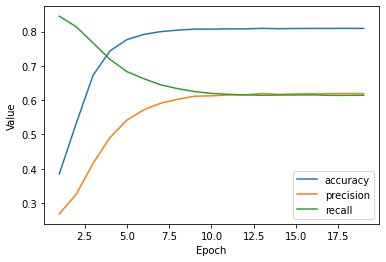

In [36]:
# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs_data, hist, list_of_metrics_to_plot)

### <font color='darkgreen'>Task 4: Experiment with the classification threshold (if time permits)</font>

Experiment with different values for `classification_threshold` in the code cell within "Invoke the creating, training, and plotting functions."  What value of `classification_threshold` produces the highest accuracy?

In [39]:
classification_threshold = 0.52

METRICS = [
  tf.keras.metrics.BinaryAccuracy(
      name='accuracy',  threshold=classification_threshold),
  tf.keras.metrics.Precision(
      name='precision', thresholds=classification_threshold),
  tf.keras.metrics.Recall(
      name='recall', thresholds=classification_threshold),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs_data, hist = train_model(
  my_model, train_df_norm, epoch_round, label_name, batch_size)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


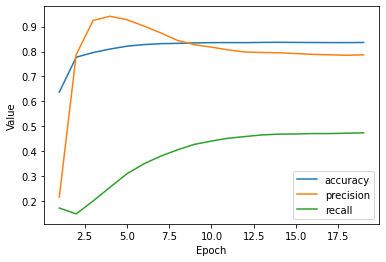

In [40]:
# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs_data, hist, list_of_metrics_to_plot)

# A `classification_threshold` of slightly over 0.5
# appears to produce the highest accuracy (about 83%).
# Raising the `classification_threshold` to 0.9 drops 
# accuracy by about 5%.  Lowering the 
# `classification_threshold` to 0.3 drops accuracy by 
# about 3%. 

### <font color='darkgreen'>Task 5: Summarize model performance (if time permits)</font>

If time permits, add one more metric that attempts to summarize the model's overall performance. 

<font color='darkred'><b>Hints</b></font>: 
> <b><a href='https://en.wikipedia.org/wiki/Receiver_operating_characteristic'>AUC</a></b> (Area under the curve) is one of the most important evaluation metrics for measuring the performance of any classification model. It is a performance measurement for a classification problem at various thresholds settings.  ([source](https://docs.paperspace.com/machine-learning/wiki/auc-area-under-the-roc-curve))

In [41]:
# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(
  my_model, train_df_norm, epoch_round, label_name, batch_size)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


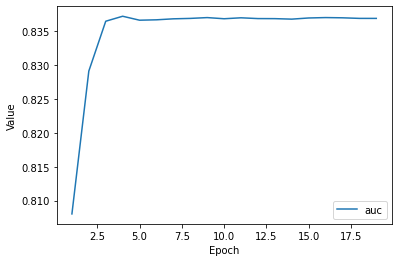

In [42]:
# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)